In [38]:
from sqlalchemy import create_engine
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()
conn
dfo = pd.read_sql_table('race', conn)
print(f'{len(dfo)} races loaded!')
dfo = dfo.loc[dfo['race_type'].isin(['R'])]
print(f'{len(dfo)} horse races!')

7306 races loaded!
2426 horse races!


In [40]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,2426.000000,2426.000000,2426.00000,2426.000000
mean,4393.744023,4.654575,1658.82028,9.610058
std,1977.221171,2.498538,758.13690,2.912123
min,1610.000000,1.000000,790.00000,3.000000
25%,2446.250000,3.000000,1200.00000,7.000000
50%,4297.500000,5.000000,1400.00000,9.000000
75%,6151.750000,7.000000,1800.00000,12.000000
max,7857.000000,12.000000,6400.00000,22.000000


In [41]:
# bet size
balance = 1000
bet_chunk = balance * 0.05

In [42]:
def process_strategy(df, strategy):
    """run strategy"""

    book = []
    for _, race in dfo.iterrows():
#         print(race['num_runners'])

        runners = race['runners']

        runners, num_bets = strategy(runners, bet_chunk)
#         except KeyError:
#             continue

        bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])

    return book

In [43]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    num_runners = num_runners
    win_diff = 0
    max_diff = 0
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                profit = runner['bet'] * runner['odds_win'] - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [37]:
def bet_positive_odds(runners, bet_chunk):
    """if prob > odds, bet"""
    
    def bettable(r):
        return (r['probability'] > r['odds_scale'] and r['odds_win'] > 0)

    # total (only of runners we are betting on)
    all_odds_scaled = [r['odds_scale'] for r in runners if bettable(r)]
    num_bets = len(all_odds_scaled)
    total = sum(all_odds_scaled)
    
    for runner in runners:
        runner['bet'] = runner['odds_scale'] / total * bet_chunk if bettable(runner) else 0

    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_odds)

Dataframe shuffled!


In [10]:
df = pd.DataFrame(book)
df.tail(10)

,bet_chunk,max_diff,num_bets,num_runners,profit,race_type,runners,success,win_diff
2416,50.0,0.000172,7,10.0,-50.000000,R,"[{'runnerName': 'BLUE PETAL', 'runnerNumber': ...",0,0.000172
2417,50.0,0.042148,8,9.0,0.195450,R,"[{'runnerName': 'NIKKAS 'N' A TWIST', 'runnerN...",1,0.010885
2418,50.0,0.044322,11,13.0,-50.000000,R,"[{'runnerName': 'NEWTOWN', 'runnerNumber': 16,...",0,0.017798
2419,50.0,0.006743,4,11.0,-50.000000,R,"[{'runnerName': 'WALDPFAD', 'runnerNumber': 11...",0,0.006743
2420,50.0,0.087354,7,8.0,-5.816352,R,"[{'runnerName': 'BORN TO FIGHT', 'runnerNumber...",1,0.073436
2421,50.0,0.006495,5,12.0,56.413151,R,"[{'runnerName': 'MORE THAN ALRIGHT', 'runnerNu...",1,0.000821
2422,50.0,0.040139,2,7.0,21.979866,R,"[{'runnerName': 'SNOOKERED', 'runnerNumber': 5...",1,0.040139
2423,50.0,0.065827,1,8.0,47.500000,R,"[{'runnerName': 'BALL GIRL', 'runnerNumber': 4...",1,0.065827
2424,50.0,0.115388,6,9.0,0.284643,R,"[{'runnerName': 'MY GIRL HAYLEY', 'runnerNumbe...",1,0.032661
2425,50.0,0.094267,11,11.0,-8.809281,R,"[{'runnerName': 'RED STRIPES', 'runnerNumber':...",1,0.004900


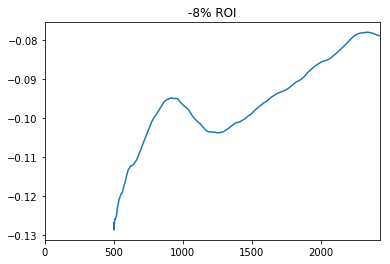

In [31]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.0f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(500).mean().plot(title=roi_title)

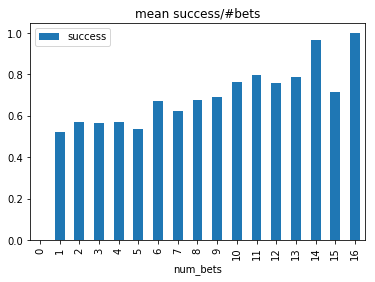

In [16]:
# profit per num bets 
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='mean success/#bets')

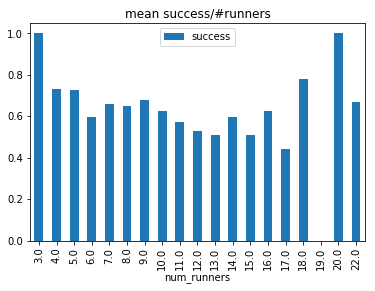

In [17]:
# profit per num runners
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='mean success/#runners')

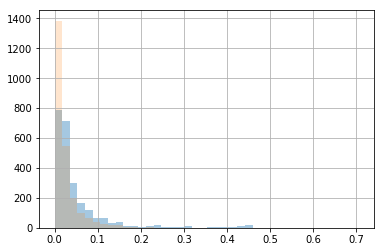

In [26]:
# max diff
df.max_diff.hist(bins=40, alpha=.4)
df.win_diff.hist(bins=40, alpha=.2)

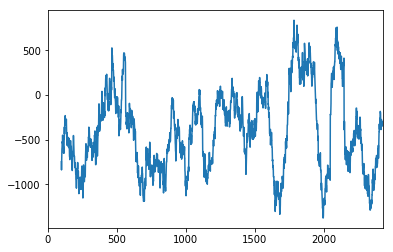

In [34]:
df.profit.rolling(100).sum().plot()